In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from py2neo import Graph, Node, Relationship
from neo4j import GraphDatabase
from yfiles_jupyter_graphs import GraphWidget

%matplotlib inline

In [2]:
# Neo4j database connection details
# Please change this details to your corresponding server information
db_url = 'bolt://localhost:7687'
db_username = 'neo4j'
db_password = '12345678'

In [3]:
# Establishing a connection with Neo4j database
# NB: Ensure your Neo4j database server is running before running the cell
try:
    # py2neo
    graph = Graph(db_url, auth=(db_username, db_password))
    # neo4j
    driver = GraphDatabase.driver(uri=db_url,auth=(db_username,db_password))
    session = driver.session()
except:
    print('Please ensure your graph database server is running and accurate information are provided')

In [4]:
# URL to the dataset
url = 'https://data.snb.ch/api/cube/auvercurra/data/csv/en'

In [5]:
# Import csv files
def import_csv(url, header=None):
    df = pd.read_csv(url, header=header, skiprows=[0,1], sep=';')
    print('Dataset imported')
    return df

# Printing the dataset shape
def data_shape(df):
    print(f'Shape of data: {df.shape}\n')

# Printing the dataset information 
def data_details(df):
    print(f'{df.describe()}\n{df.info()}\n')

# Checking for missing values
def check_na(df):
    print(f'NULL COUNT\n{df.isna().sum()}\n')

# Viewing samples of the dataset
def data_preview(df, num):
    print(f'{df.head(num)}\n')

# Getting the latest year with missing value
def max_empty_entry_year(df):
    empty_entry_years = []
    
    # Iterate over the data
    for i in range(len(df)):
        
        # Test if the value is empty
        if pd.isna(df['Value'][i]) == True:
            temp_year = df['Date'][i]
            empty_entry_years.append(temp_year)
    return max(empty_entry_years)

# Acquire sequential years with complete values
def get_complete_year(df):
    # Get the latest year with missing value
    start_year = max_empty_entry_year(df)
    
    # Get the last year on the data
    end_year = df.iloc[0,-1]

    # Extract years with complete data between the latest year with missing value and last year on the data
    new_df = df[((df['Date'] > start_year)&(df['Date']<= end_year))]
    new_df.reset_index(drop=True, inplace=True)
    return new_df

# Rename columns
def col_rename(df, dic):
    df.rename(columns=dic, inplace=True)

# Replace values in the dataframe
def replace_values(df, dic):
    for temp_col in dic:
        df[temp_col] = df[temp_col].map(dic[temp_col]).fillna(df[temp_col])

# Extract unique values in the dataframe
def extract_unique_values(df, col):
   for i in col:
      if i == 'Category':
         category = df[i].unique()
      elif i == 'Currency':
         currency = df[i].unique()
      elif i == 'Investment':
         investment = df[i].unique()
   return category, currency, investment


# Plot of total assets and liabilities
def plot_trend_asset_liability(df):
    
    # Duplicate the dataframe
    temp_df = df.copy(deep=True)
    
    # Scaling of 'Value' column
    temp_df['Value'] = temp_df['Value']/1000
    
    # Filtering the dataframe for Total Assets
    filter_df_asset = temp_df[temp_df['Category'] == 'Assets']
    filter_df_asset = filter_df_asset[filter_df_asset['Currency'] == 'Total (in CHF)']

    # Filtering the dataframe for Total Liabilities
    filter_df_liability = temp_df[temp_df['Category'] == 'Liability']
    filter_df_liability = filter_df_liability[filter_df_liability['Currency'] == 'Total (in CHF)']
    
    # Set the plot style
    sns.set(style="whitegrid")

    # Plot the trend using Seaborn
    plt.figure(figsize=(10, 6))  # Set the figure size
            
    sns.lineplot(x='Date', y='Value', label='Asset', data=filter_df_asset)
    sns.lineplot(x='Date', y='Value', label='Liability', data=filter_df_liability)

    # Customize the plot
    plt.xticks(temp_df['Date'].unique(), rotation=45)
    plt.title('Plot of Total Assets and Liabilities')
    plt.xlabel('Year')
    plt.ylabel('Values (in Billions CHF)')
    plt.legend()

    # Show the plot
    plt.show()
    
# Plot of assets in different currencies
def plot_trend_asset(df):
    
    # Duplicate the dataframe
    temp_df = df.copy(deep=True)
    
    # Scaling of 'Value' column
    temp_df['Value'] = temp_df['Value']/1000
    
    # Filtering the dataframe for assets
    filter_df_asset = temp_df[temp_df['Category'] == 'Assets']
    
    # Filtering the dataframe for total assets in each currencies
    filter_df_asset = filter_df_asset[filter_df_asset['Investment'] == 'Total Investment']
    
    filter_df_usd = filter_df_asset[filter_df_asset['Currency'] == 'USD']
    filter_df_eur = filter_df_asset[filter_df_asset['Currency'] == 'EUR']
    filter_df_chf = filter_df_asset[filter_df_asset['Currency'] == 'CHF']
    filter_df_other = filter_df_asset[filter_df_asset['Currency'] == 'Other Currencies ']
    filter_df_metals = filter_df_asset[filter_df_asset['Currency'] == 'Precious Metals']

    
    # Filtering the dataframe for liabilities
    filter_df_liabilities = temp_df[temp_df['Category'] == 'Liability']
    
    # Filtering the dataframe for total liabilities in each currencies
    filter_df_liabilities = filter_df_liabilities[filter_df_liabilities['Investment'] == 'Total Investment']
    
    filter_df_l_usd = filter_df_liabilities[filter_df_liabilities['Currency'] == 'USD']
    filter_df_l_eur = filter_df_liabilities[filter_df_liabilities['Currency'] == 'EUR']
    filter_df_l_chf = filter_df_liabilities[filter_df_liabilities['Currency'] == 'CHF']
    filter_df_l_other = filter_df_liabilities[filter_df_liabilities['Currency'] == 'Other Currencies ']
    filter_df_l_metals = filter_df_liabilities[filter_df_liabilities['Currency'] == 'Precious Metals']


    # Set the plot style
    sns.set(style="whitegrid")

    # Plot the trend using Seaborn
    plt.figure(figsize=(10, 6))  # Set the figure size
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10,12))

    # Plots for first axes        
    sns.lineplot(x='Date', y='Value', ax=ax1, label='USD', data=filter_df_usd)
    sns.lineplot(x='Date', y='Value', ax=ax1, label='EUR', data=filter_df_eur)
    sns.lineplot(x='Date', y='Value', ax=ax1, label='CHF', data=filter_df_chf)
    sns.lineplot(x='Date', y='Value', ax=ax1, label='Other Currencies', data=filter_df_other)
    sns.lineplot(x='Date', y='Value', ax=ax1, label='Precious Metals', data=filter_df_metals)
    
    # Customize the plot
    ax1.set_title('Plot of Assets in Different Currencies')
    ax1.set_ylabel('Values (in Billions)')
    ax1.legend()

    # Plot for second axes
    sns.lineplot(x='Date', y='Value', ax=ax2, label='USD', data=filter_df_l_usd)
    sns.lineplot(x='Date', y='Value', ax=ax2, label='EUR', data=filter_df_l_eur)
    sns.lineplot(x='Date', y='Value', ax=ax2, label='CHF', data=filter_df_l_chf)
    sns.lineplot(x='Date', y='Value', ax=ax2, label='Other Currencies', data=filter_df_l_other)
    sns.lineplot(x='Date', y='Value', ax=ax2, label='Precious Metals', data=filter_df_l_metals)
    
    # Customize the plot
    plt.xticks(temp_df['Date'].unique(), rotation=45)
    ax2.set_title('Plot of Liabilities in Different Currencies')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Values (in Billions)')
    ax2.legend()

    # Adjust layout to avoid subplot features overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()


# Plot stacked barchart
def plot_barchart_investment(df):
    
    # Duplicate the dataframe
    temp_df = df.copy(deep=True)
    
    # Scaling of 'Value' column
    temp_df['Value'] = temp_df['Value']/1000
    
        
    # Set the plot style (optional)
    sns.set(style="whitegrid")

    # Filtering the dataframe for Total Assets
    filter_df = temp_df[temp_df['Category'] == 'Net International Investment']
    filter_df = filter_df[filter_df['Investment'] == 'Total Investment']

    # Excluding 'Total (in CHF)'
    filter_df = filter_df[filter_df['Currency'] != 'Total (in CHF)']

    # Create the stacked bar chart 
    pivot_df = filter_df.pivot(index='Date', columns='Currency', values='Value')
    pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

    # Customize the plot
    plt.title(f'Plot of Net International Investment over Available Currencies')
    plt.xticks(rotation=45)
    plt.xlabel('Year')
    plt.ylabel('Values (in Billions)')
    plt.legend()
    
    # Show the plot
    plt.show()

# Plot graphs
def plot_graphs(df):
    #plot total asset and liability over the years
    plot_trend_asset_liability(df)

    # Plot asset and liability breakdown by currencies
    plot_trend_asset(df)

    # Plot barcharts
    plot_barchart_investment(df)
    
    
# Get minimum value with the corresponding year
def get_min_value(df):
    # Get index of minimum value
    idx = df['Value'].idxmin()
    
    # Get minimum value
    value = min(df['Value'])
    
    # Get minimum year
    year = df['Date'][idx]
    return value, year

# Get maximum value with the corresponding year
def get_max_value(df):
    # Get index of maximum value
    idx = df['Value'].idxmax()
    
    # Get maximum value
    value = max(df['Value'])
    
    # Get maximum year
    year = df['Date'][idx]
    return value, year

# Get mean value
def get_mean_value(df):
    mean = df['Value'].mean()
    return mean

# Get dataset statics information
def statics_arr(df, col):
    tab = []
    
    # Get unique values in different columns
    category, currency, investment = extract_unique_values(df, col)
    
    for i in category:
        for j in investment:
            for k in currency:

                # Filtering the database
                temp_df = df[(df['Category']==i)&(df['Investment']==j)&(df['Currency']==k)]
                if temp_df.empty == True:
                    continue
                
                # Get minimum value with the corresponding year
                min_val, min_yr = get_min_value(temp_df)

                # Get maximum value with the corresponding year
                max_val, max_yr = get_max_value(temp_df)

                # Get mean value
                mean_val = get_mean_value(temp_df)
                temp_arr = [i, j, k, min_val, min_yr, max_val, max_yr, mean_val]
                tab.append(temp_arr)
    return tab

# Convert array to dataframe
def arr_to_df(arr, columns):
    tab_df = pd.DataFrame(arr, columns=columns)
    return tab_df

# Empty graph database
def empty_database():
    query = f'''MATCH (n) DETACH DELETE n'''
    graph.run(query)
    print('Database emptied!')

# Create constraint
def constraint():
    # Creating a constraint if not exist to enusre row id is a unique attribute to the value node
    graph.run("CREATE CONSTRAINT IF NOT EXISTS FOR (v:Value) REQUIRE v.id IS UNIQUE")
    print('Constraint created')


# Write to neo4j database
def write_to_graphdb(df):
    dataset_length = len(df) 
    for i in range(dataset_length):
        if pd.isna(df['Value'][i]) == True:
            # Replacing missing values with NaN
            amount = 'NaN'
        else:
            # Converting value column to integer
            amount=int(df['Value'][i])

        # Define the nodes
        new_investment = Node('Investment', name=df['Investment'][i])
        currency = Node('Currency', code=df['Currency'][i])
        value = Node('Value', amount=amount, id=i, multiplier='million')

        # Define the relationship
        investment_currency = Relationship(new_investment, 'IN', currency, type=df['Category'][i])
        currency_value = Relationship(currency, 'EQUIVALENCE_OF', value, year=int(df['Date'][i]))

        # Create the nodes and relationships
        graph.merge(new_investment, 'Investment', 'name')
        graph.merge(currency, 'Currency', 'code')
        graph.merge(investment_currency)
        graph.merge(value, 'Value', 'amount')
        graph.merge(currency_value)
        
    print('Data written to database')

# Retrieve information from Neo4j database
def retrive_data(limit=0):
    if limit == 'ALL':
        result = session.run(f"MATCH (investment:Investment)-[investment_currency:IN]->(currency:Currency)-[investment_year:EQUIVALENCE_OF]->(value:Value) RETURN investment, investment_currency, currency, investment_year, value")
    else:
        result = session.run(f"MATCH (investment:Investment)-[investment_currency:IN]->(currency:Currency)-[investment_year:EQUIVALENCE_OF]->(value:Value) RETURN investment, investment_currency, currency, investment_year, value LIMIT {limit}")
    return result

# Display graph database information
def display_graph(result):
    w = GraphWidget(graph = result.graph())
    w.show()

# Extracting all data in the graph database
def extract_data(): 

    #Creating an empty array to hold the result       
    arr = []

    # Retriving all nodes and relationships in the database
    result = retrive_data(limit='ALL')

    # Process the result
    for record in result:
        investment = record['investment']
        investment_currency = record['investment_currency']
        currency = record['currency']
        investment_year = record['investment_year']
        value = record['value']
        relationship_type = investment_currency['type']
        value_id = value['id']
        
        
        # Storing result in an array
        temp_arr = [value_id, investment_year['year'], currency['code'], relationship_type, investment['name'], value['amount']]
        arr.append(temp_arr)

    # Print completion message 
    print('Data Extracted')
    
    return arr    


# Sort dataframe by column
def sort_df(df, col):
    new_df = df.sort_values(by=col, inplace=False)
    return new_df

In [6]:
# Import dataset
data = import_csv(url, header=0)

# Preview dataset
data_preview(data, 10)

Dataset imported
   Date   D0 D1  D2          Value
0  1985    T  A   T  533563.900000
1  1985    T  P   T  324924.212761
2  1985    T  N   T  208639.687239
3  1985    T  N  D0   21781.100000
4  1985    T  N   P  101025.700000
5  1985    T  N  D1            NaN
6  1985    T  N  UI   35787.887239
7  1985    T  N   W   50045.000000
8  1985  CHF  A   T  207103.100000
9  1985  CHF  A  D0   15158.800000



In [7]:
# Print dataset shape 
data_shape(data)

Shape of data: (2394, 5)



In [8]:
# Print dataset information
data_details(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2394 entries, 0 to 2393
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2394 non-null   int64  
 1   D0      2394 non-null   object 
 2   D1      2394 non-null   object 
 3   D2      2394 non-null   object 
 4   Value   2143 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 93.6+ KB
              Date         Value
count  2394.000000  2.143000e+03
mean   2003.500000  2.860143e+05
std      10.968147  6.475766e+05
min    1985.000000 -2.639072e+06
25%    1994.000000  1.476964e+04
50%    2003.500000  1.050115e+05
75%    2013.000000  3.298119e+05
max    2022.000000  5.660224e+06
None



In [9]:
# Check for missing values
check_na(data)

NULL COUNT
Date       0
D0         0
D1         0
D2         0
Value    251
dtype: int64



In [10]:
# Delete years with missing values
new_data = get_complete_year(data)

# Preview edited data
data_preview(new_data, 10)

   Date   D0 D1  D2         Value
0  2004    T  A   T  2.315959e+06
1  2004    T  P   T  1.757195e+06
2  2004    T  N   T  5.587632e+05
3  2004    T  N  D0  2.014493e+05
4  2004    T  N   P  2.708061e+05
5  2004    T  N  D1 -2.643000e+03
6  2004    T  N  UI  4.688357e+03
7  2004    T  N   W  8.446248e+04
8  2004  CHF  A   T  3.824364e+05
9  2004  CHF  A  D0  2.001220e+04



In [11]:
# Print data shape
data_shape(new_data)

Shape of data: (1197, 5)



In [12]:
# Print data information
data_details(new_data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1197 non-null   int64  
 1   D0      1197 non-null   object 
 2   D1      1197 non-null   object 
 3   D2      1197 non-null   object 
 4   Value   1197 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 46.9+ KB
              Date         Value
count  1197.000000  1.197000e+03
mean   2013.000000  3.937786e+05
std       5.479515  8.163989e+05
min    2004.000000 -2.639072e+06
25%    2008.000000  2.199060e+04
50%    2013.000000  1.586427e+05
75%    2018.000000  4.774740e+05
max    2022.000000  5.660224e+06
None



In [13]:
# Check for missing values
check_na(new_data)

NULL COUNT
Date     0
D0       0
D1       0
D2       0
Value    0
dtype: int64



In [14]:
# Columns name dictionary
col_name = {'D0':'Currency', 'D1':'Category', 'D2':'Investment'}

# Rename columns
col_rename(new_data, col_name)

# Preview data
data_preview(new_data, 10)

   Date Currency Category Investment         Value
0  2004        T        A          T  2.315959e+06
1  2004        T        P          T  1.757195e+06
2  2004        T        N          T  5.587632e+05
3  2004        T        N         D0  2.014493e+05
4  2004        T        N          P  2.708061e+05
5  2004        T        N         D1 -2.643000e+03
6  2004        T        N         UI  4.688357e+03
7  2004        T        N          W  8.446248e+04
8  2004      CHF        A          T  3.824364e+05
9  2004      CHF        A         D0  2.001220e+04



C:\Users\bamik\AppData\Local\Temp\ipykernel_18536\3475778415.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns=dic, inplace=True)


In [15]:
# Columns values dictionary
col = {'Currency': {'T': 'Total (in CHF)', 'UW': 'Other Currencies', 'E': 'Precious Metals'},
'Category': {'A': 'Assets', 'P': 'Liability', 'N': 'Net International Investment'},
'Investment': {'T': 'Total Investment', 'D0': 'Direct Investment', 'P': 'Portfolio Investment', 'D1': 'Derivative', 'UI': 'Other Investments', 'W': 'Reserve Assets'}}

# Replacing of columns values
replace_values(new_data, col)

# Preview of data
data_preview(new_data, 10)

   Date        Currency                      Category            Investment  \
0  2004  Total (in CHF)                        Assets      Total Investment   
1  2004  Total (in CHF)                     Liability      Total Investment   
2  2004  Total (in CHF)  Net International Investment      Total Investment   
3  2004  Total (in CHF)  Net International Investment     Direct Investment   
4  2004  Total (in CHF)  Net International Investment  Portfolio Investment   
5  2004  Total (in CHF)  Net International Investment            Derivative   
6  2004  Total (in CHF)  Net International Investment     Other Investments   
7  2004  Total (in CHF)  Net International Investment        Reserve Assets   
8  2004             CHF                        Assets      Total Investment   
9  2004             CHF                        Assets     Direct Investment   

          Value  
0  2.315959e+06  
1  1.757195e+06  
2  5.587632e+05  
3  2.014493e+05  
4  2.708061e+05  
5 -2.643000e+03  
6  4

C:\Users\bamik\AppData\Local\Temp\ipykernel_18536\3475778415.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[temp_col] = df[temp_col].map(dic[temp_col]).fillna(df[temp_col])
C:\Users\bamik\AppData\Local\Temp\ipykernel_18536\3475778415.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[temp_col] = df[temp_col].map(dic[temp_col]).fillna(df[temp_col])
C:\Users\bamik\AppData\Local\Temp\ipykernel_18536\3475778415.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [16]:
# Column names
col = ['Category', 'Currency', 'Investment']

# Acquire unique values in columns
category, currency, investment = extract_unique_values(new_data, col)

In [17]:
# Acquire data statistics information
tab = statics_arr(new_data, col)

# Columns name
columns=['Category', 'Investment Type', 'Currency', 'Min Value (Million)', 'Min Year', 'Max Value (Million)', 'Max Year', 'Mean Value']

# Convert array to dataframe
statics_df = arr_to_df(tab, columns)

# Print shape of dataframe
data_shape(statics_df)

# Preview data statistics dataframe 
data_preview(statics_df, 10)

Shape of data: (63, 8)

  Category    Investment Type          Currency  Min Value (Million)  \
0   Assets   Total Investment    Total (in CHF)         2.315959e+06   
1   Assets   Total Investment               CHF         3.824364e+05   
2   Assets   Total Investment               USD         7.272642e+05   
3   Assets   Total Investment               EUR         7.106378e+05   
4   Assets   Total Investment  Other Currencies         4.692834e+05   
5   Assets   Total Investment   Precious Metals         2.633722e+04   
6   Assets  Direct Investment               CHF         1.360510e+04   
7   Assets  Direct Investment               USD         1.166559e+05   
8   Assets  Direct Investment               EUR         1.480454e+05   
9   Assets  Direct Investment  Other Currencies         2.346568e+05   

   Min Year  Max Value (Million)  Max Year    Mean Value  
0      2004         5.660224e+06      2021  4.134675e+06  
1      2004         6.196003e+05      2008  4.825948e+05  
2     

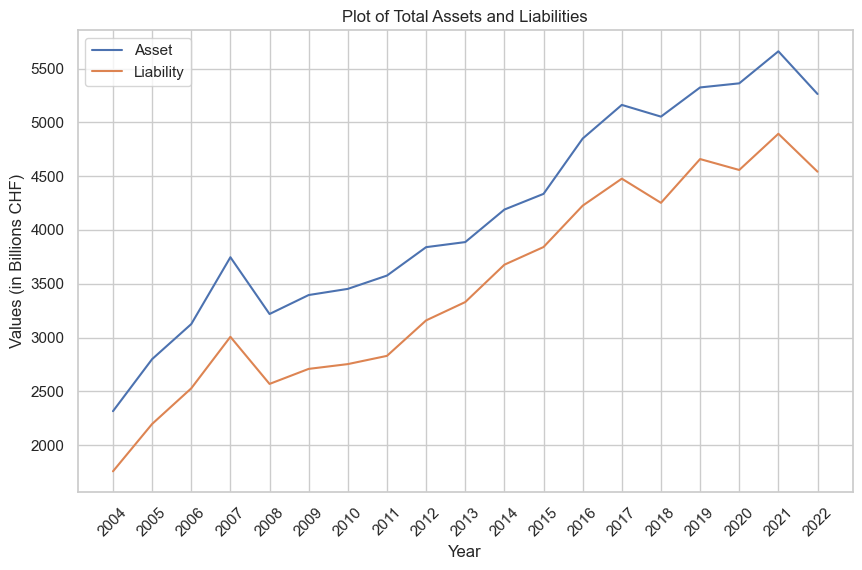

<Figure size 1000x600 with 0 Axes>

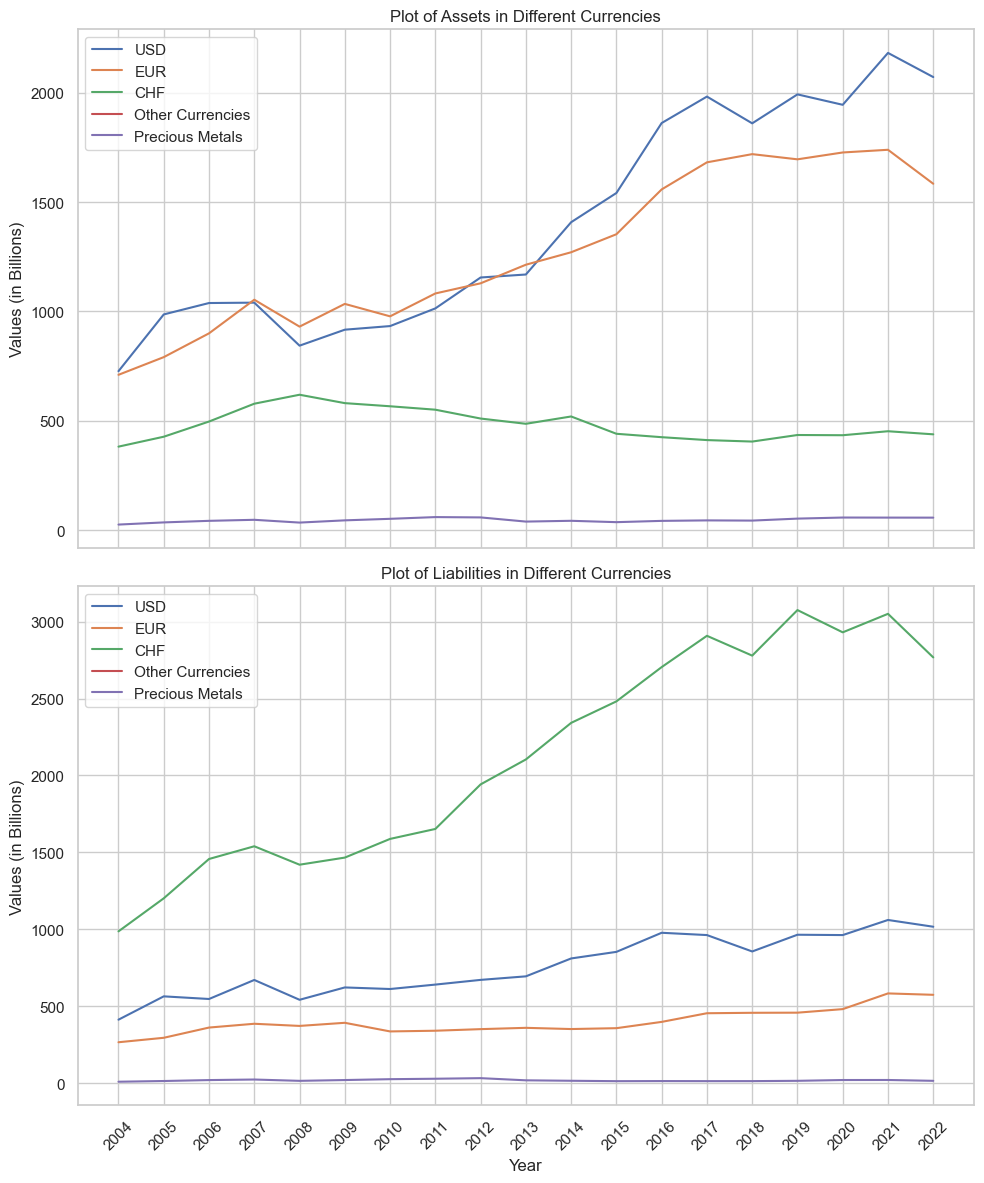

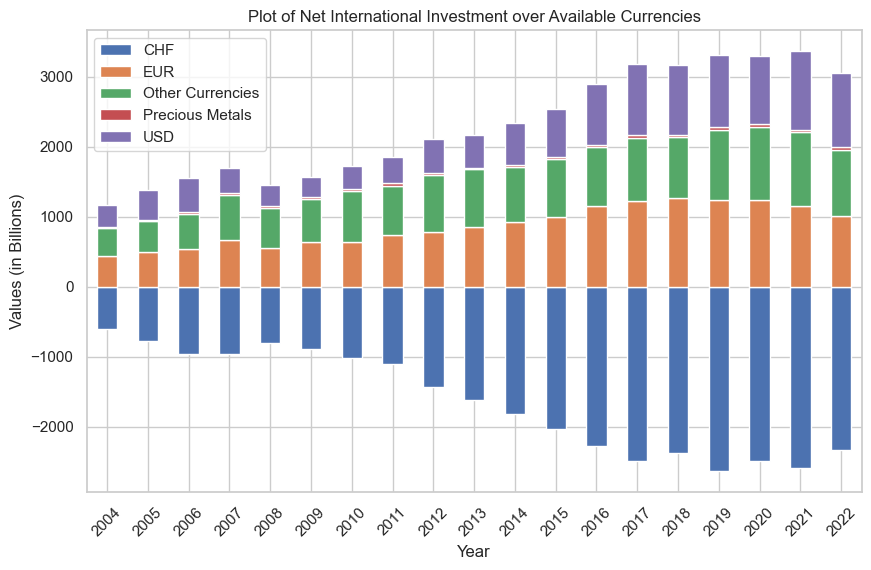

In [18]:
# Plot graphs
plot_graphs(new_data)

In [19]:
# Empty database
# CAUTION: THIS CELL WILL DELETE ALL THE GRAPHS IN THE CONNECTED DATABASE
empty_database()

Database emptied!


In [20]:
# Making constaint before creating the graph
constraint()

Constraint created


In [21]:
# Write data to graph
write_to_graphdb(new_data)

Data written to database


In [22]:
# Retrive nodes and connections
r = retrive_data(1)

# Display retrived nodes and connections 
display_graph(r)

GraphWidget(layout=Layout(height='500px', width='100%'))

In [23]:
# Retrive nodes and connections
r1 = retrive_data(len(new_data))

# Display retrived nodes and connections 
display_graph(r1)

GraphWidget(layout=Layout(height='500px', width='100%'))

In [24]:
# Extract all nodes and relationships in the database
extracted_array = extract_data()

Data Extracted


In [25]:
# Columns name for the array
columns=['Id','Year', 'Currency', 'Category', 'Investment', 'Value(Millions)']

# Covert the array to dataframe
df_extracted_array = arr_to_df(extracted_array, columns)

# Sort the dataframe using the retrived id
sorted_extracted_array = sort_df(df_extracted_array, 'Id')

# Print shape of dataframe
data_shape(sorted_extracted_array)

# Preview data statistics dataframe 
data_preview(sorted_extracted_array, 30)

Shape of data: (6653, 6)

      Id  Year        Currency                      Category  \
4432   0  2004  Total (in CHF)  Net International Investment   
6609   0  2004  Total (in CHF)  Net International Investment   
2194   0  2004  Total (in CHF)  Net International Investment   
1149   0  2004  Total (in CHF)  Net International Investment   
3239   0  2004  Total (in CHF)  Net International Investment   
5625   0  2004  Total (in CHF)  Net International Investment   
6610   1  2004  Total (in CHF)  Net International Investment   
2195   1  2004  Total (in CHF)  Net International Investment   
4433   1  2004  Total (in CHF)  Net International Investment   
3240   1  2004  Total (in CHF)  Net International Investment   
1150   1  2004  Total (in CHF)  Net International Investment   
5626   1  2004  Total (in CHF)  Net International Investment   
5627   2  2004  Total (in CHF)  Net International Investment   
6611   2  2004  Total (in CHF)  Net International Investment   
3241   2  2004